### SUMMARY
look into training set raw captions text:
1. check how many captions have emoji **(emoji)**
2. how many have username mentioned
3. how many mixed with hashtag i.e. word prefixed with #
4. see if name entity detection work **(huggingface)**
5. catch mis-spelled word **(spacy + hunspell)**

### REFERENCE
1. Name entity extraction (huggingface): https://huggingface.co/transformers/usage.html
2. Handle mis-spelled words: https://github.com/tokestermw/spacy_hunspell
3. Training a sentiment model: https://github.com/bentrevett/pytorch-sentiment-analysis
4. List of available models for all tasks: https://huggingface.co/models?filter=text-classification
5. How to use huggingface's pipeline for NER/ sentiment analysis: https://huggingface.co/transformers/main_classes/pipelines.html
6. NER: 
    - available arguments: https://huggingface.co/transformers/main_classes/pipelines.html#transformers.TokenClassificationPipeline
7. sentiment classifier: 
    - available arguments: https://huggingface.co/transformers/main_classes/pipelines.html#textclassificationpipeline
    - Kaggle: pretrained sentiment model pretrained on 1.6 million Twitter dataset: https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis
    - DeepMoji from huggingface: https://medium.com/huggingface/understanding-emotions-from-keras-to-pytorch-3ccb61d5a983
 

In [1]:
import os
import json
import re
from collections import defaultdict, Counter
from multiprocessing import Pool

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emoji

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import spacy
from spacy_hunspell import spaCyHunSpell

nlp = spacy.load('en_core_web_sm')
hunspell = spaCyHunSpell(nlp, 'linux')
nlp.add_pipe(hunspell)

/usr/share/hunspell/en_US.dic /usr/share/hunspell/en_US.aff


In [3]:
JSON_PATH = '../../../data/instagram/json/insta-caption-train.json'

with open(JSON_PATH, 'r') as f:
    data = json.load(f)
    
captions = dict()
for usr, usr_dict in data.items():
    for post, post_dict in usr_dict.items():
        id_key = f'{usr}_@_{post}'
        caption = post_dict['caption'].strip()
        captions[id_key] = caption
        
len(captions)

648761

### 1. How many captions have emoji?
Caveat:
- treat :))))) --> :)

In [4]:
def is_emoji(text):
    boo = False
    for c in text:
        if c in emoji.UNICODE_EMOJI: boo = True
    return boo

In [5]:
emoji_cnt = 0
instance_n = 5

for _, caption in captions.items():
    if is_emoji(caption): 
        emoji_cnt += 1
        if instance_n != 0:
            print(caption)
            instance_n -= 1

print(f'\ncaption with emoji: {emoji_cnt} ({len(captions)})')

Best part of the day 🍹
I wouldn't be where I am today🙏🏽
Took Blackgirl out for a drive today but this wind is real disrespectful ☀️☀️
Shop with us and add some ✨Bliss✨to your life
Happy Thanksgiving! Hope everyone is having a ✨Blissful✨ Holiday.

caption with emoji: 109013 (648761)


In [6]:
def is_target_face(text):
    boo = False
    if (":)" in text) or (":(" in text):
        boo = True
    return boo

In [7]:
face_cnt = 0
instance_n = 5

for _, caption in captions.items():
    if is_target_face(caption): 
        face_cnt += 1
        if instance_n != 0:
            print(caption)
            instance_n -= 1

print(f'\ncaption with emoji: {face_cnt} ({len(captions)})')

Why does she give me those puppy eyes :( 👀🐶
Going to see ze babies:)
Why do my TWO FAVORITE shows have their season opening at the same time:(
I get to make these all day at work:)))
Melissa's gender reveal was a success!! So glad everything turned out nicely:) #ItsAGirl

caption with emoji: 18755 (648761)


### 2a. How many have username mention?

In [8]:
re.findall(r'@[\S]+', '@riven_hong.asdas-314 hi world')

['@riven_hong.asdas-314']

In [9]:
def is_username(text):
    pattern = re.findall(r'@[\S]+', text)
    if len(pattern) != 0:
        return True
    else:
        return False

In [10]:
username_cnt = 0
instance_n = 5

for _, caption in captions.items():
    if is_username(caption): 
        username_cnt += 1
        if instance_n != 0:
            print(caption)
            instance_n -= 1

print(f'\ncaption with user name: {username_cnt} ({len(captions)})')

Bob life and loving it @crimsonsfi9est
Shop @blissboutiquear for this top also come in white
You killed this look @mz_marvelous_dr
Beauty @7jessicasally rocking Bliss very well.
My crew tonight minus @kinkykurlydiva she was swiping those cards!  Everything Blis

caption with user name: 36034 (648761)


### 2b. A Special Username

In [11]:
def is_double_at(text):
    pattern = '@@'
    if pattern in text:
        return True
    else:
        return False

In [12]:
special_cnt = 0
instance_n = 10

for _, caption in captions.items():
    if is_double_at(caption):
        special_cnt += 1
        if instance_n != 0:
            print(caption)
            instance_n -= 1

print(f'\ncaption with author name: {special_cnt} ({len(captions)})')

Started a band and scooted around on some stools with @@goldie.senpai today 😍😘

caption with author name: 1 (648761)


In [13]:
re.sub(r"([!?,\.\"])", r" ", 'I am loving it!!!')

'I am loving it   '

### 3a. How many mixed with hashtag? 

In [14]:
def capture_hashtag(text):
    pattern = re.findall(r'#[\S]+', text)
    if len(pattern) != 0:
        return pattern
    else:
        return None

In [15]:
hashtag_cnt = 0
hashtag_set = Counter()
instance_n = 100

for _, caption in captions.items():
    hashtags = capture_hashtag(caption)
    
    if hashtags is not None:    
        hashtag_set.update(hashtags)
        
        hashtag_cnt += 1
        if instance_n != 0:
            print(caption)
            instance_n -= 1

print(f'\ncaption with hashtag: {hashtag_cnt} ({len(captions)})')

I'm going to get it one day. #selfie game
Mood: Feeling so grateful today and wanted to put some cuteness on your timeline #Journee'
My new friend at vista! #treelizard
My beautiful niece a year ago and then yesterday. #loveher
This is how I like to sit at work. #relaxed
It was that kind of day. #tired
Listen to the saying! Do it. #texasgirl
The face of a natural born killer. #problems #longmorning
Ladies cross their legs, even at 1800+ feet high. #classy
Thanks to my Aunt Eleanor in Boston for this awesome #cowboys bracelet!!
Literally forgot I asked her to call me that haha. #night
The man who made this trip happen and made me happen lol. #mydad
For real! #repost
Had to #repost! This made me and @meliarlene laugh!
20 years ago at the Oscars. #crazy.
#SafeSets ready for domination this season!
Got use out of my puffer jacket today. #cold #sick #work
All these years and I thought that space was meant for motorcycles. #sillyme
You live by your own perception. #quoteoftheday
#tbt my baby

### 3b. How many caption have residual word after hashtag? 
e.g. "I like chocolate! #teatime coffe like"

In [16]:
test1 = "I'm going to get it one day. #selfie game"
test2 = "I'm going to get it one day. #selfie game"

In [17]:
re.split(r'(#[\S]+)', test1, 0)

["I'm going to get it one day. ", '#selfie', ' game']

### 3c. Distribution of hashtags?

In [18]:
all_hashtag_tup = sorted(list(hashtag_set.items()), key = lambda x: x[1], reverse = True)
sum([cnt for tag, cnt in all_hashtag_tup if cnt <= 5])

84138

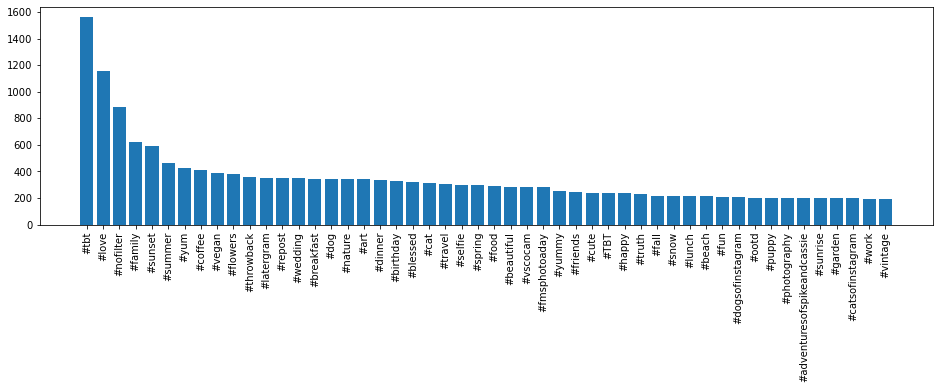

In [19]:
sorted_tup = sorted(list(hashtag_set.items()), key = lambda x: x[1], reverse = True)[:50]

hashtag_ls, cnt_ls = map(list, zip(*sorted_tup))

fig, ax = plt.subplots(1, figsize = (16, 4))
ax.bar(hashtag_ls, cnt_ls)
ax.set_xticklabels(labels = hashtag_ls, rotation = 90);

### 3d. Distribution of Position where hashtag occur

In [20]:
def hashtag_positions(text):
    positions = [pos for pos, char in enumerate(text) if char == '#']
    if len(positions) == 0:
        return None
    else:
        return positions

In [21]:
position_counter = Counter()

for _, caption in captions.items():
    positions = hashtag_positions(caption)
    
    if positions is not None:    
        caption_len = len(caption)
        positions = [idx/ caption_len for idx in positions]
        position_counter.update(positions)

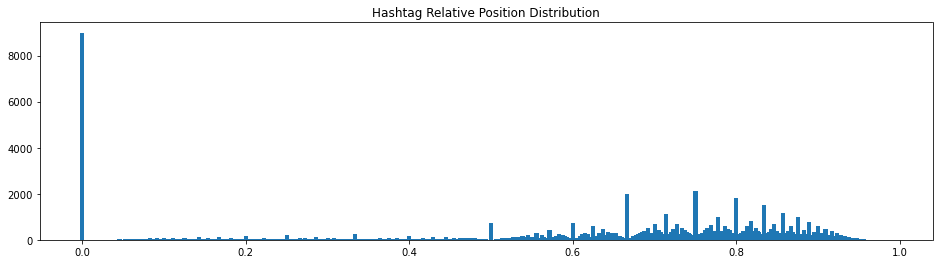

In [22]:
sorted_tup = sorted(list(position_counter.items()), key = lambda x: x[0], reverse = False)

position_ls, cnt_ls = map(list, zip(*sorted_tup))

fig, ax = plt.subplots(1, figsize = (16, 4))
ax.bar(position_ls, cnt_ls, width = 0.005)
ax.set_title('Hashtag Relative Position Distribution');
#ax.set_xticklabels(labels = position_ls, rotation = 45);

In [23]:
first = sum([cnt for pos, cnt in sorted_tup if pos <= 1/3])
mid = sum([cnt for pos, cnt in sorted_tup if (pos <= 2/3) and (pos > 1/3)])
end = sum([cnt for pos, cnt in sorted_tup if (pos > 2/3)])

print(first)
print(mid)
print(end)

20907
35627
113628


### 3e. Among Those Hashtag, How many are mispelled?

In [36]:
mispell_cnt = 0
mispell_set = dict()
hashtag_ls = list(hashtag_set.keys())

clean_hashtag_ls = [hashtag.replace('#', '') for hashtag in hashtag_ls]
docs = nlp.pipe(clean_hashtag_ls)

for i, doc in tqdm(enumerate(docs)):
    hashtag = hashtag_ls[i]
    cnt = hashtag_set[hashtag]
    if not doc[0]._.hunspell_spell:
        mispell_set[hashtag] = cnt
        mispell_cnt += cnt

total_tags = sum([cnt for tag, cnt in hashtag_set.items()])
print(f'mispelled hashtag: {mispell_cnt} ({total_tags}) ({(mispell_cnt/total_tags):.3f})')

66652it [00:17, 3748.84it/s]

mispelled hashtag: 87576 (169199) (0.518)


In [37]:
mispell_set

{"#Journee'": 1,
 '#treelizard': 1,
 '#loveher': 44,
 '#texasgirl': 1,
 '#longmorning': 1,
 '#mydad': 2,
 '#repost': 352,
 '#repost!': 1,
 '#SafeSets': 1,
 '#sillyme': 2,
 '#quoteoftheday': 16,
 '#tbt': 1559,
 '#killme': 3,
 '#whyisthishappening': 1,
 '#juggernots': 1,
 '#countrymusic': 2,
 '#utsa': 1,
 '#lazydog': 7,
 '#weightwatchers': 10,
 '#prettylittleliars': 3,
 '#imissyou': 4,
 '#noteventempted': 1,
 '#HeLovesMe': 1,
 '#lovemyjob': 26,
 '#doesithavetoend': 1,
 '#shehatesme': 1,
 '#Brightonjewelry': 1,
 '#dogowner': 1,
 '#getoutofmyhead': 1,
 '#throwbackthursday': 129,
 '#harrypotter': 19,
 '#ItsAGirl': 1,
 '#CatchingFire': 2,
 '#UTSA': 1,
 '#morningcrew': 1,
 '#breckenridge!': 1,
 '#mostbeautifullittlegirl': 1,
 '#vegas': 34,
 '#gottastartsomewhere': 1,
 '#wehavefun': 1,
 '#chicago': 47,
 '#vscocam': 279,
 '#saddog': 2,
 '#nelsonnelsonwedding': 1,
 '#WorldCatDay...': 1,
 '#howheasked': 1,
 '#omgYES': 1,
 '#stackmeplease': 1,
 '#thatsawesome': 1,
 '#nyc': 105,
 '#iwantthis': 1,
 

In [38]:
test_mispell_hashtags = [
    'treelizard', 'letu!', 'wannabeinmygang', '#HowLuckyIAm', 'birdwatching'
]

for mispell_hashtag in test_mispell_hashtags:
    print(nlp(mispell_hashtag)[0]._.hunspell_suggest)

['tree lizard', 'tree-lizard', 'treeline']
['lech', 'lute', 'let', 'letup', 'lets']
[]
['e', 's', 'i', 'a', 'n', 'r', 't', 'o', 'l', 'c', 'd', 'u', 'g', 'm', 'p']
['bird watching', 'bird-watching', 'birdwatcher']


### 4. Name Entity Detection (Person Name)?
select a good tokenizer and pretrained model

In [139]:
from transformers import pipeline
nlp = pipeline("ner", device = 0)

In [115]:
def capture_person_name(caption_tup):
    id_key, caption = caption_tup
    print(f'processing: {id_key}')
    out = nlp(caption)
    if len(out) != 0 and (out[0]['entity'] == 'I-PER' or out[0]['entity'] == 'B-PER'):
        ner_ls = [d['word'] for d in out]
        return (id_key, ner_ls)
    else:
        return None

In [122]:
caption_key, caption_txt = zip(*captions.items())

assert len(caption_key) == len(caption_txt)

In [142]:
test_docs = list(caption_txt)[:100]

In [143]:
%timeit ner_outs = nlp(test_docs)
#ner_tup = [(id_key, ner_ls) for id_key, ner_ls in zip(caption_key, ner_outputs)]

1.51 s ± 39.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [146]:
((1.51 / 100) * 600000) / 3600

2.5166666666666666

### 5. Sentiment Detection
select a good tokenizer and good pretrained model

**Candidate**
- https://huggingface.co/vicd/sentiment?text=Fix+it+please%21
- https://huggingface.co/amine/multilingual_sentiment_vocab20k?text=Fix+it+please%21

In [136]:
senti_nlp = pipeline('sentiment-analysis', device = 0)

In [147]:
caption_txt[:100]

("I'm way up I feel Bless.",
 'About to bleed the block for a second',
 'Aztec dress will be available tomorrow and added to the site',
 'Both Black and White are now available for ordering',
 'Date Night with Bae! Rocking "Treasure" only 1 available on site',
 'Bob life and loving it @crimsonsfi9est',
 'Grey joggers also added to the site',
 "Jumpsuit heaven! Can't wait for Vegas",
 'Over size Denim Shirt will be available next week',
 'Shop site for new arrivals',
 'New arrivals have been added to the site',
 'Today was a good day I must say! More sales to come stay tune',
 'Shop @blissboutiquear for this top also come in white',
 'You killed this look @mz_marvelous_dr',
 'She holds me down. My big baby',
 '"Comfy" type of day',
 'Hammer Hammer I am! Late post! Sorry ladies both colors are sold out',
 'About to get food. I will smile once I eat!',
 'My baby girl rocking her Bermuda from Bliss!! My Minnie me',
 'Fix it please!',
 'Beauty @7jessicasally rocking Bliss very well.',
 'Bes

In [148]:
test_docs = 'Fix it please!'
senti_nlp(test_docs)

[{'label': 'POSITIVE', 'score': 0.9461995959281921}]

### Appendix 1: Other Text Processing

In [24]:
import spacy

nlp = spacy.load('en_core_web_sm')
test = "i'm loving it!@username"

In [25]:
doc = nlp(test)

for i in doc:
    print(i.text)

i
'm
loving
it!@username


### Appendix 2: Mispell Correction

In [5]:
samples = [
    "Slit joggers added to site. Killin it top still available",
    "Thanks to my Aunt Eleanor in Boston for this awesome #cowboys bracelet!!",
    "Had to #repost! This made me and @meliarlene laugh!",
    "Available for purchase. Size S M L",
    "My baby girl rocking her Bermuda from Bliss!! My Minnie me"
]

In [7]:
docs = nlp.pipe(samples)

for doc in docs:
    print(f'tokens: {[w.text for w in doc]}')
    print(f'mispell: {[w.text for w in doc if not w._.hunspell_spell]}\n')

tokens: ['Slit', 'joggers', 'added', 'to', 'site', '.', 'Killin', 'it', 'top', 'still', 'available']
mispell: ['Killin']

tokens: ['Thanks', 'to', 'my', 'Aunt', 'Eleanor', 'in', 'Boston', 'for', 'this', 'awesome', '#', 'cowboys', 'bracelet', '!', '!']
mispell: ['#', '!', '!']

tokens: ['Had', 'to', '#', 'repost', '!', 'This', 'made', 'me', 'and', '@meliarlene', 'laugh', '!']
mispell: ['#', 'repost', '!', '@meliarlene', '!']

tokens: ['Available', 'for', 'purchase', '.', 'Size', 'S', 'M', 'L']
mispell: []

tokens: ['My', 'baby', 'girl', 'rocking', 'her', 'Bermuda', 'from', 'Bliss', '!', '!', 'My', 'Minnie', 'me']
mispell: ['!', '!']



In [13]:
doc = nlp(samples[1])
doc[11].text
doc[11]._.hunspell_spell

True

In [14]:
doc = nlp('@username this is amazing! @username')
print([i.text for i in doc])

['@username', 'this', 'is', 'amazing', '!', '@username']


In [28]:
doc.retokenize()

In [30]:
doc = nlp('cheeze')
doc[0]._.hunspell_spell, doc[0]._.hunspell_suggest

(False, ['cheese', 'wheeze'])

In [40]:
doc = nlp("Going to see ze babies:)")
doc[3]._.hunspell_spell, doc[3]._.hunspell_suggest

(False,
 ['z',
  'e',
  'zen',
  'zed',
  're',
  'me',
  'he',
  'be',
  'ye',
  'we',
  'Se',
  'Ne',
  'Re',
  'Te',
  'Le'])